In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from joblib import load
from utils.dscarnet import dual_dscarnet
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil

2026-01-08 17:32:30.245004: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
name = "AC"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
)

In [3]:
data = pd.read_csv('dataset/data.csv', low_memory = False)
data['label'] = data['label'].replace({r'\b(PEPH|NaPE)\b': 'PE', r'\b(peph)\b': 'pe'}, regex = True)
data['label'] = data['label'].str.strip()
mask = (data['label'] == '0') | (data['label'].str.contains('/', na=False))
data_nontarget_index, data_target_index = data.index[mask], data.index[~mask]

X1 = load('dataset/sherloc_x1.data')
X2 = load('dataset/sherloc_x2.data')

classes = ['OL', 'PE', 'PX', 'SU', 'SI', 'CA']
class2idx = {c: i for i, c in enumerate(classes)}

def multilabel_to_vector(label_str):
    vec = np.zeros(len(classes))
    s = str(label_str).strip()
    if s == '0' or s == ' ':
        return vec
    for lbl in s.split("/"):
        lbl = lbl.strip().upper()
        idx = class2idx.get(lbl)
        if idx is not None:
            vec[idx] = 1
    return vec

Y = np.stack([multilabel_to_vector(lbl) for lbl in data['label']])

In [4]:
def make_weighted_ce(class_weights, label_smoothing = 0.05):
    w = tf.constant(class_weights, dtype = tf.float32)
    ce = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing = label_smoothing,
        reduction = tf.keras.losses.Reduction.NONE
    )
    def loss_fn(y_true, y_pred):
        per_sample = ce(y_true, y_pred)             
        sample_w = tf.reduce_sum(w * y_true, axis = -1)  
        return tf.reduce_mean(per_sample * sample_w)
    return loss_fn

In [5]:
df_target_idx = pd.RangeIndex(0, 4501).intersection(data_target_index)

train_idx, valid_idx = train_test_split(
    df_target_idx,
    test_size = 0.2,
    random_state = 42,
    stratify = data.loc[df_target_idx, "label"]
)

X1_train, X2_train, Y_train = X1[train_idx], X2[train_idx], Y[train_idx]
X1_valid, X2_valid, Y_valid = X1[valid_idx], X2[valid_idx], Y[valid_idx]

trainX, validX = (X1_train, X2_train), (X1_valid, X2_valid)
trainY, validY = Y_train, Y_valid

positive_counts = np.maximum((trainY > 0).sum(axis = 0), 1)      
orig_weights = trainY.shape[0] / (len(positive_counts) * positive_counts)
median_w = np.median(orig_weights)
class_weights = np.minimum(orig_weights, median_w * 10)

In [6]:
model = dual_dscarnet(X1.shape[1:], X2.shape[1:], n_outputs = len(classes), last_avf = "softmax")
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4, clipnorm = 1.0)
loss = make_weighted_ce(class_weights, label_smoothing = 0.05)
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 20, min_lr = 1e-6, verbose = 0),
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 0),
]

2026-01-08 17:32:32.092798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 17:32:33.097952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:cc:00.0, compute capability: 8.0


In [7]:
history = model.fit(
    trainX, trainY,
    validation_data = (validX, validY),
    batch_size = 32,
    epochs = 1000,
    shuffle = True,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/1000


2026-01-08 17:32:37.483019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2026-01-08 17:32:40.071577: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


59/59 [==============================] - 10s 43ms/step - loss: 1.6875 - accuracy: 0.4033 - val_loss: 1.6949 - val_accuracy: 0.5150 - lr: 1.0000e-04
Epoch 2/1000
59/59 [==============================] - 2s 33ms/step - loss: 1.4488 - accuracy: 0.5838 - val_loss: 1.3274 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 3/1000
59/59 [==============================] - 2s 35ms/step - loss: 1.2328 - accuracy: 0.6396 - val_loss: 1.1518 - val_accuracy: 0.7060 - lr: 1.0000e-04
Epoch 4/1000
59/59 [==============================] - 2s 30ms/step - loss: 1.0840 - accuracy: 0.7229 - val_loss: 1.0779 - val_accuracy: 0.7811 - lr: 1.0000e-04
Epoch 5/1000
59/59 [==============================] - 2s 32ms/step - loss: 0.9747 - accuracy: 0.7637 - val_loss: 0.9800 - val_accuracy: 0.8219 - lr: 1.0000e-04
Epoch 6/1000
59/59 [==============================] - 2s 33ms/step - loss: 0.9206 - accuracy: 0.7905 - val_loss: 0.9213 - val_accuracy: 0.8283 - lr: 1.0000e-04
Epoch 7/1000
59/59 [==============================] 

In [8]:
loss, acc = model.evaluate(trainX, trainY, verbose = 0)
print("Train Accuracy:", acc)        
loss, acc = model.evaluate(validX, validY, verbose = 0)
print("Valid Accuracy:", acc)


Train Accuracy: 0.9398496150970459
Valid Accuracy: 0.9055793881416321


In [31]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

dense64 = next(l for l in model.layers if isinstance(l, Dense) and l.units == 64)
feature_model = Model(inputs=model.inputs, outputs=dense64.input)

In [32]:
Z_train  = feature_model.predict(trainX, batch_size=128, verbose=0)
Z_valid  = feature_model.predict(validX, batch_size=128, verbose=0)

n_features = Z_train.shape[1]
feature_cols = [f"f{i}" for i in range(n_features)]

df_train = pd.DataFrame(Z_train, columns=feature_cols)
df_valid = pd.DataFrame(Z_valid, columns=feature_cols)

df_train["idx"] = train_idx
df_valid["idx"] = valid_idx

df_all = pd.concat([df_train, df_valid], axis=0, ignore_index=True)

labels = data.loc[df_all["idx"], "label"].reset_index(drop=True)
df_all["label"] = labels

df_all = df_all.sort_values("idx").reset_index(drop=True)
df_all["label"] = df_all["label"].replace({"PE": "PE/PH", "pe": "pe/ph"})

In [33]:
df_all.to_csv("dataset/AC2AC_UMAP.csv", index=False)

In [34]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_all.iloc[:,:128]) 

In [35]:
import umap
reducer = umap.UMAP(
    n_neighbors=10,     
    min_dist=1,      
    n_components=2,     
    metric='cosine',   
    random_state=0
)
X_umap = reducer.fit_transform(X)     

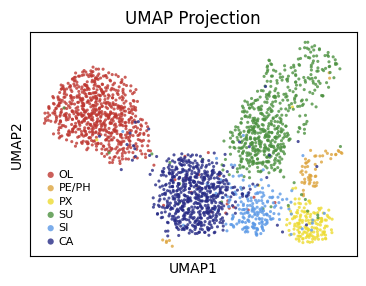

In [36]:
color_map = {
    'OL': "#BE3731",
    'PE/PH': "#DDA43D",
    'PX': "#EDDB31",
    'SU': "#4C9140",
    'SI': "#5B99E6",
    'CA': "#262A85"
}

plt.figure(figsize=(4.2, 3.2))
subset = df_all.copy()
subset['label_upper'] = subset['label'].str.upper()

for label, color in color_map.items():
    idx = subset[subset['label_upper'] == label].index
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], s=5, alpha=0.8, 
                c=color, label=label, edgecolors='none')

plt.xlabel('UMAP1', fontsize=10)
plt.ylabel('UMAP2', fontsize=10)
plt.title('UMAP Projection', fontsize=12)
plt.legend(
    frameon=False,         
    markerscale=2,         
    fontsize=8,
    handletextpad=-0.3,
    labelspacing=0.3,
    loc='best'
)
plt.tight_layout()
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                   right=False, labelbottom=False, labelleft=False)
plt.savefig("figure/2f.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
